<a href="https://colab.research.google.com/github/anniesurla/GenerativeAIExamples/blob/dev%2Fasurla-llama-nemotron-vl/Llama_Nemotron_VL_8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Copyright 2025 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" align="right" width="100px"/>

# Llama Nemotron Nano VL 8B - A Simple Notebook Walkthrough!
Explore NVIDIA's 8B Vision Language Model capable of OCR and Document Understanding. You can use this notebook to try out [Llama Nemotron Nano VL model](https://build.nvidia.com/nvidia/llama-3.1-nemotron-nano-vl-8b-v1) - hosted on [build.nvidia.com](https://build.nvidia.com/).

All you need to run this model is an NVIDIA API KEY, which you can find on the model page linked above by clicking on "Get API Key". Make sure to login or sign up!

![image](https://i.imgur.com/QNuiro2.png)

> NOTE: Don't worry about any credits to use this model, although there is a rate limit of 40 requests per minute.

In [2]:
import os
import getpass

os.environ["NVIDIA_API_KEY"] = getpass.getpass("Provide NVDEV API Key: ")

In case, you are running this notebook in a local environment, let's ensure we install all the required libraries to run this notebook.

In [3]:
%pip install pyarrow matplotlib pandas openai requests Pillow

Note: you may need to restart the kernel to use updated packages.


### Set up OpenAI Client
First, we'll need to point our OpenAI client to build.nvidia.com API

In [4]:
from openai import OpenAI

client = OpenAI(
  base_url = "https://integrate.api.nvidia.com/v1",
  api_key = os.environ["NVIDIA_API_KEY"]
)

Let's also create a function that calls Llama Nemotron Nano VL. This function takes image(s) and text prompt as input, and gives out the model response.

We will have to combine the text prompt along with the images to craft a prompt to the model. Dive deeper into the API Reference [here](https://docs.api.nvidia.com/nim/reference/nvidia-llama-3_1-nemotron-nano-vl-8b-v1).

> Best Practice: Order of items in the messages dictionary matter. First put your images, and then your text prompt.

In [5]:
def call_llama_nemotron_nano_vl(images_b64_list, text_prompt):
  """
  Calls the Llama Nemotron Nano VL model with image(s) and a text prompt.
  Returns: Model's output response as a string.
  """

  messages = [
    {
        "role": "user",
        "content": []
    }
  ]

  for image_b64 in images_b64_list:

    messages[0]['content'].append(
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/png;base64,{image_b64}"}
        }
    )

  messages[0]["content"].append(
      {
          "type": "text",
          "text": text_prompt
      }
  )

  chat_response = client.chat.completions.create(
      model="nvidia/llama-3.1-nemotron-nano-vl-8b-v1",
      messages=messages,
      max_tokens=1024,
      temperature=0.0,
      stream=False
  )

  return chat_response.choices[0].message.content

### Invoice/Receipt Understanding

We are going to demonstrate the capability of this small VLM on an invoice. This model shines with it's OCR capabilities. Let's grab an invoice from a dataset on HuggingFace [katanaml-org/invoices-donut-data-v1](https://huggingface.co/datasets/katanaml-org/invoices-donut-data-v1). We are going to pull an invoice image from the test set of this dataset.

In [6]:
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import io

!wget https://huggingface.co/datasets/katanaml-org/invoices-donut-data-v1/resolve/main/data/test-00000-of-00001-56af6bd5ff7eb34d.parquet

table = pq.read_table("test-00000-of-00001-56af6bd5ff7eb34d.parquet")
df = table.to_pandas()

--2025-06-05 15:59:49--  https://huggingface.co/datasets/katanaml-org/invoices-donut-data-v1/resolve/main/data/test-00000-of-00001-56af6bd5ff7eb34d.parquet
Resolving huggingface.co (huggingface.co)... 18.164.174.118, 18.164.174.55, 18.164.174.17, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.118|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/8b/53/8b532de81ab76db9001c6481db8bba0d5b5ec4539ffe0aaebec9bcfafdadaba2/712a9a65000d6a2cf04d41bc794843ca30452bb87473951b1adafd3610eab08b?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27test-00000-of-00001-56af6bd5ff7eb34d.parquet%3B+filename%3D%22test-00000-of-00001-56af6bd5ff7eb34d.parquet%22%3B&Expires=1749167990&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0OTE2Nzk5MH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy84Yi81My84YjUzMmRlODFhYjc2ZGI5MDAxYzY0ODFkYjhiYmEwZDViNWVjNDUzOWZmZTBhYWViZWM5YmNmYWZkYWRhYmEy

Let's select a random image from the data.

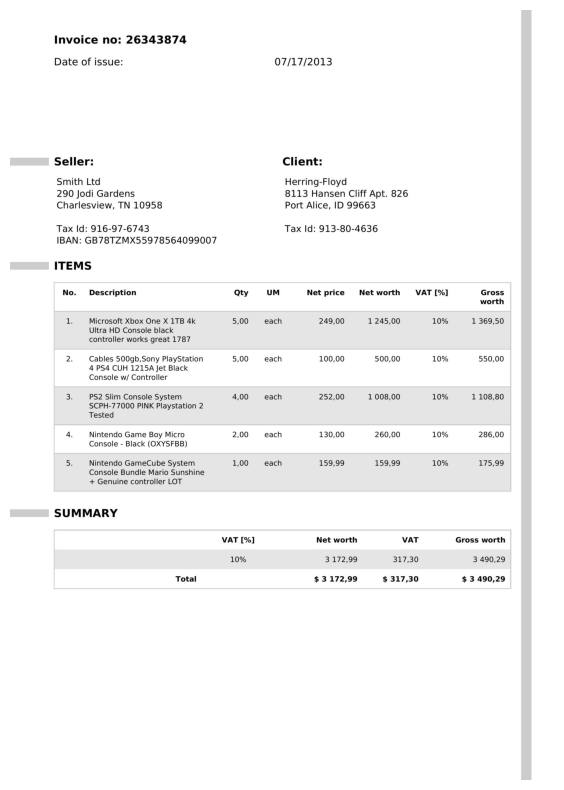

In [7]:
from PIL import Image
import io

img_bytes = df.loc[6, 'image']['bytes']
img = Image.open(io.BytesIO(img_bytes))

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

Starting with simple transcription. But before that we also need to convert our image to base64 encoded string.

>Best Practice: When images have tables, ask the model to extract in LaTeX format for an accurate full page OCR.

In [8]:
import base64

buffered = io.BytesIO()
img.save(buffered, format="PNG")
img_bytes = buffered.getvalue()

# Encode to base64 string
image_b64 = base64.b64encode(img_bytes).decode()

text_prompt = """Transcribe this document in reading order. Format tables with LaTeX."""

We are now ready to prompt the model.

In [9]:
assistant_message = call_llama_nemotron_nano_vl(images_b64_list=[image_b64], text_prompt=text_prompt)

print(assistant_message)

Invoice no: 26343874

Date of issue: 07/17/2013

Seller:

Smith Ltd 290 Jodi Gardens Charlesview, TN 10958

Tax Id: 916-97-6743 IBAN: GB78TZMX55978564099007

Client:

Herring-Floyd 8113 Hansen Cliff Apt. 826 Port Alice, ID 99663

Tax Id: 913-80-4636

ITEMS

SUMMARY

\begin{tabular}{cccccccc} **No.** & **Description** & **Qty** & **UM** & **Net price** & **Net worth** & **VAT [%]** & **Gross worth**\\ 1. & Microsoft Xbox One X 1TB 4k Ultra HD Console black controller works great 1787 & 5,00 & each & 249,00 & 1 245,00 & 10% & 1 369,50\\ 2. & Cables 500gb,Sony PlayStation 4 PS4 CUH 1215A Jet Black Console w/ Controller & 5,00 & each & 100,00 & 500,00 & 10% & 550,00\\ 3. & PS2 Slim Console System SCPH-77000 PINK Playstation 2 Tested & 4,00 & each & 252,00 & 1 008,00 & 10% & 1 108,80\\ 4. & Nintendo Game Boy Micro Console - Black (OXYSFBB) & 2,00 & each & 130,00 & 260,00 & 10% & 286,00\\ 5. & Nintendo GameCube System Console Bundle Mario Sunshine + Genuine controller LOT & 1,00 & each & 159

You can now transcribe invoices for quick extraction of content. This model is also capable at answering questions on an image.

Let's ask a question on the invoice to get a Monetary insight.

>Best Practice: Be concise and Don't be vague on your ask.

In [10]:
text_prompt = """Are there discounts or adjustments applied? Answer with one word, yes or no."""

assistant_message = call_llama_nemotron_nano_vl(images_b64_list=[image_b64], text_prompt=text_prompt)

print(assistant_message)

No


In [11]:
text_prompt = """What is the tax rate applied on items?"""

assistant_message = call_llama_nemotron_nano_vl(images_b64_list=[image_b64], text_prompt=text_prompt)

print(assistant_message)

10%


You can ask a question to do line-level Item Analysis.

In [12]:
text_prompt = """How many items are billed?"""

assistant_message = call_llama_nemotron_nano_vl(images_b64_list=[image_b64], text_prompt=text_prompt)

print(assistant_message)

5


Try to prompt for Entity Detection!

In [13]:
text_prompt = """Are there any logos or branding that indicate a company identity? Say either yes or no."""

assistant_message = call_llama_nemotron_nano_vl(images_b64_list=[image_b64], text_prompt=text_prompt)

print(assistant_message)

No, there are no visible logos or branding that indicate a company identity in the provided image.


In [14]:
text_prompt = """Are any handwritten or stamped elements in the invoice?"""

assistant_message = call_llama_nemotron_nano_vl(images_b64_list=[image_b64], text_prompt=text_prompt)

print(assistant_message)

Based on the image, there are no visible handwritten or stamped elements on the invoice. All text appears to be printed, with no signs of alterations or additional markings that would indicate hand-written or stamped content.


This time, let's grab an example image from the web. Again, first we need to convert the image to a base64-encoded string.

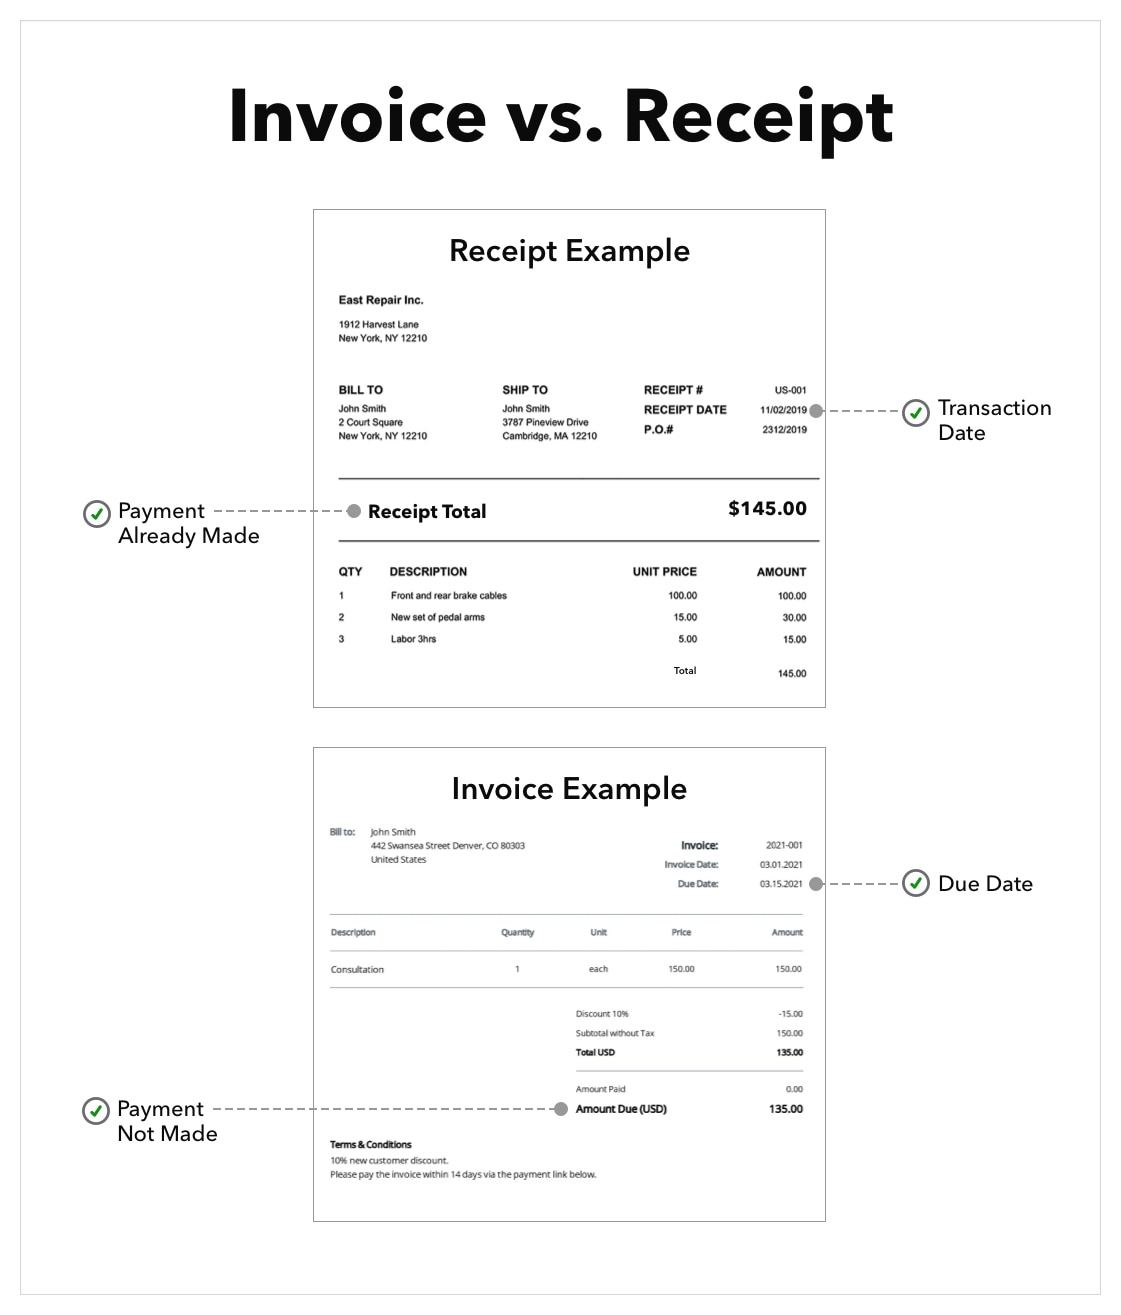

In [15]:
import base64
import requests
from IPython.display import Image, display, Markdown


image_url = "https://quickbooks.intuit.com/oidam/intuit/sbseg/en_us/Blog/Graphic/invoice-vs-receipt.png"

def url_to_base64(url):
    response = requests.get(url)
    response.raise_for_status()  # Raise error if request failed
    encoded = base64.b64encode(response.content)
    return encoded.decode()

image_b64 = url_to_base64(image_url)

display(Image(image_url, width=400, height=500))

Starting with simple transcription.

In [16]:
text_prompt = """Transcribe this image word to word."""

assistant_message = call_llama_nemotron_nano_vl(images_b64_list=[image_b64], text_prompt=text_prompt)

print(assistant_message)

Invoice vs. Receipt

Receipt Example

East Repair Inc.
1912 Harvest Lane
New York, NY 12210

BILL TO
John Smith
2 Court Square
New York, NY 12210

SHIP TO
John Smith
3787 Pineview Drive
Cambridge, MA 12210

RECEIPT #
RECEIPT DATE
P.O.#
US-001
11/02/2019
2312/2019

Transaction Date

Receipt Total

$145.00

QTY
DESCRIPTION
UNIT PRICE
AMOUNT

1
Front and rear brake cables
100.00
100.00

2
New set of pedal arms
15.00
30.00

3
Labor 3hrs
5.00
15.00

Total
145.00

Invoice Example

Bill to:
John Smith
442 Swanssea Street Denver, CO 80303
United States

Invoice:
Invoice Date:
Due Date:

03.01.2021
03.15.2021

Description
Quantity
Unit
Price
Amount

Consultation
1
each
150.00
150.00

Discount 10%
Subtotal without Tax
Total USD

-15.00
150.00
135.00

Amount Paid
0.00

Amount Due (USD)
135.00

Terms & Conditions
10% new customer discount.
Please pay the invoice within 14 days via the payment link below.


Let's prompt to test the model's ability to understand different tables in an image.

In [17]:
text_prompt = """What's the total amount paid on the receipt and invoice?"""

assistant_message = call_llama_nemotron_nano_vl(images_b64_list=[image_b64], text_prompt=text_prompt)

print(assistant_message)

The total amount paid on the receipt is $145, and on the invoice is $135.


It accurately pulled and mapped the totals to receipt and invoice.

Let's ask an extractive question.

In [18]:
text_prompt= "When was the invoice issued?"

assistant_message = call_llama_nemotron_nano_vl(images_b64_list=[image_b64], text_prompt=text_prompt)

print(assistant_message)

The invoice was issued on 03.01.2021.


Llama Nemotron Nano VL is also good at text grounding, accurately telling where text is located in the image.

In [19]:
text_prompt = "Where are the terms and conditions written?"

assistant_message = call_llama_nemotron_nano_vl(images_b64_list=[image_b64], text_prompt=text_prompt)

print(assistant_message)

The terms and conditions are written at the bottom of the invoice example.


## 📌 Conclusion



In this notebook, we explored the capabilities of **Llama Nemotron Nano VL 8B**, a lightweight vision-laguage model developed by NVIDIA, through invoice and document understanding tasks.

Here is a quick summary of what we achieved:
- ✅ Performed **OCR-based transcription** with strong layout awareness and LaTeX formatting.
- 💬 Asked **semantic questions** about discounts, tax rates, and itemized billing.
- 🔍 Evaluated the model's ability to **detect entities** and **text grounding** abilities.

> Llama Nemotron Nano VL 8B proves to be an efficient and practical tool for intelligent document processing at scale. It is especially useful for developers looking for affordable and responsive models with OCR + question/answering capabilities.
